In [126]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

source_df = pd.read_csv("Source_data/Source_file.csv")
cleansed_df = source_df.loc[(source_df["power"] != 0) | ((source_df["speed"] == 0) & (source_df["power"] == 0))]

print(cleansed_df.describe())

            speed       power
count  452.000000  452.000000
mean    12.975531   53.113478
std      6.855738   40.554469
min      0.000000    0.000000
25%      7.294500    8.412750
50%     13.013000   56.123500
75%     18.775250   94.698250
max     24.399000  113.556000


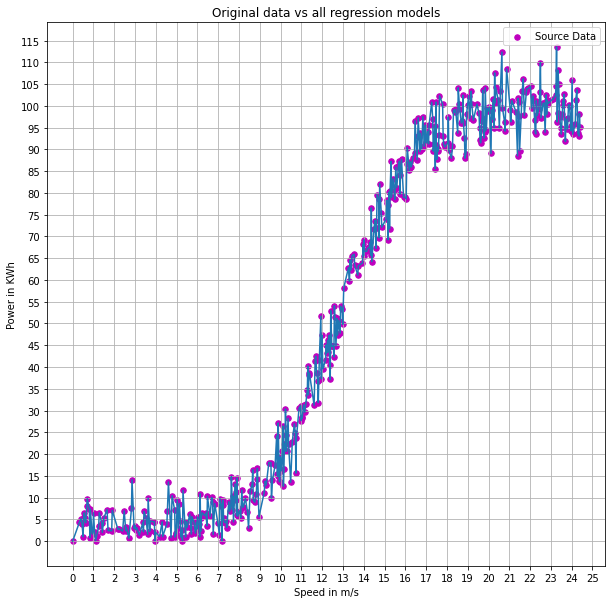

In [127]:
plt.figure(figsize = (10, 10))                                  # Set the plot size
plt.plot(cleansed_df["speed"], cleansed_df["power"])          
plt.scatter(x = cleansed_df["speed"], y = cleansed_df["power"], s = 30, color = "m", label = "Source Data")
plt.xticks(np.arange(0, round(cleansed_df["speed"].max(), 0) + 2, step = 1)) # Force all the xticks to be visible
plt.yticks(np.arange(0, round(cleansed_df["power"].max(), 0) + 4, step = 5)) # Force all the xticks to be visible
plt.grid(which = "major", axis = "x")                           # Show the minor grid lines on the x axis
plt.grid(which = "major", axis = "y")                           # Show the minor grid lines on the y axis
plt.ylabel("Power in KWh")
plt.xlabel("Speed in m/s")
plt.legend(loc = "best")
plt.title("Original data vs all regression models")
plt.show()

In [128]:
sp_ar, po_ar = cleansed_df["speed"].values, cleansed_df["power"].values

sp_train_ar, sp_test_ar, po_train_ar, po_test_ar = train_test_split(sp_ar, po_ar, test_size = 0.25, random_state = 37205)

print("Training set: %d rows\nTest set: %d rows" %(sp_train_ar.size, sp_test_ar.size))

Training set: 339 rows
Test set: 113 rows


## Linear Regression

In [129]:
lin_model = LinearRegression(fit_intercept=False).fit(sp_train_ar.reshape(-1,1), po_train_ar)

predictions_lin = lin_model.predict(sp_test_ar.reshape(-1,1))
np.set_printoptions(suppress = True)

filename_lin ="Models/lin_reg.pkl"
joblib.dump(lin_model, filename_lin)

mse_lin = mean_squared_error(po_test_ar, predictions_lin)
print("mse_lin:", mse_lin)

rsme_lin = np.sqrt(mse_lin)
print("rsme_lin:", rsme_lin)

r2_lin = r2_score(po_test_ar, predictions_lin)
print("R2_lin:", r2_lin)

mse_lin: 230.13348657866047
rsme_lin: 15.170151171911916
R2_lin: 0.8626621809721107


## Random Forest

In [130]:
RFR_model = RandomForestRegressor().fit(sp_train_ar.reshape(-1,1), po_train_ar)

predictions_RFR = RFR_model.predict(sp_test_ar.reshape(-1,1))

filename_RFR ="Models/RFR.pkl"
joblib.dump(RFR_model, filename_RFR)

mse_RFR = mean_squared_error(po_test_ar, predictions_RFR)
print("mse_RFR:", mse_RFR)

rsme_RFR = np.sqrt(mse_RFR)
print("rsme_RFR:", rsme_RFR)

r2_RFR = r2_score(po_test_ar, predictions_RFR)
print("R2_lin:", r2_RFR)

mse_RFR: 21.727598016668132
rsme_RFR: 4.661287163077183
R2_lin: 0.987033521419735


## Decision Tree Regressor

In [131]:
DTR_model = DecisionTreeRegressor().fit(sp_train_ar.reshape(-1,1), po_train_ar)

predictions_DTR = DTR_model.predict(sp_test_ar.reshape(-1,1))

filename_DTR ="Models/DTR.pkl"
joblib.dump(DTR_model, filename_DTR)

mse_DTR = mean_squared_error(po_test_ar, predictions_DTR)
print("mse_DTR:", mse_DTR)

rsme_DTR = np.sqrt(mse_DTR)
print("rsme_DTR:", rsme_DTR)

r2_DTR = r2_score(po_test_ar, predictions_DTR)
print("R2_lin:", r2_DTR)                                                # R2 is low, suggesting model is not correct

mse_DTR: 27.338591725663722
rsme_DTR: 5.228631917209675
R2_lin: 0.9836850229025091


## Sigmoid Regression

In [132]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

sp_array = cleansed_df["speed"].to_numpy()
po_array = cleansed_df["power"].to_numpy()

p0 = [max(po_array), np.median(sp_array), 1, min(po_array)]

popt, pcov = curve_fit(sigmoid, sp_array, po_array, p0, method = "dogbox")

x = sp_array
y = sigmoid(x, *popt)

In [133]:
lin_model_load = joblib.load(filename_lin)
DTR_model_load = joblib.load(filename_DTR)
RFR_model_load = joblib.load(filename_RFR)

Power_est_df = pd.DataFrame(columns = ["speed", "Lin P", "RFR P", "DTR P", "Sig P", "TL", "TR", "TD", "TS", "AMEL", "AMER",
                                      "AMED", "AMES"])

i = 0
j = 0

while j < len(cleansed_df.index):
    
    i = cleansed_df.iloc[j]["speed"]
    speed = np.full(shape=1, fill_value=i, dtype="float64").reshape(-1, 1)
    Power_est_df.loc[j, "speed"] = i
    Power_est_df.loc[j, "Lin P"] = np.round(lin_model_load.predict(speed)[0], 3)
    Power_est_df.loc[j, "RFR P"] = np.round(RFR_model_load.predict(speed)[0], 3)
    Power_est_df.loc[j, "DTR P"] = np.round(DTR_model_load.predict(speed)[0], 3)
    Power_est_df.loc[j, "Sig P"] = np.round(sigmoid(i, *popt), 3)
      
    j += 1

Power_est_df = Power_est_df.apply(pd.to_numeric, errors="coerce")  

Analysis_df = pd.merge(cleansed_df, Power_est_df, left_on = "speed", right_on = "speed", how = "left")

j = 0

while j < len(cleansed_df.index):
    if np.round(Analysis_df.loc[j, "Lin P"], 3) == np.round(Analysis_df.loc[j, "power"], 3):
        Analysis_df.loc[j,"TL"] = 1
    else:
        Analysis_df.loc[j,"TL"] = 0

    if np.round(Analysis_df.loc[j, "RFR P"], 3) == np.round(Analysis_df.loc[j, "power"], 3):
        Analysis_df.loc[j,"TR"] = 1
    else:
        Analysis_df.loc[j,"TR"] = 0

    if np.round(Analysis_df.loc[j, "DTR P"], 3) == np.round(Analysis_df.loc[j, "power"], 3):
        Analysis_df.loc[j,"TD"] = 1
    else:
        Analysis_df.loc[j,"TD"] = 0
    
    if np.round(Analysis_df.loc[j, "Sig P"], 3) == np.round(Analysis_df.loc[j, "power"], 3):
        Analysis_df.loc[j,"TS"] = 1
    else:
        Analysis_df.loc[j,"TS"] = 0
        
    Analysis_df.loc[j, "speed"] = np.round(Analysis_df.loc[j, "speed"], 3)

    Analysis_df.loc[j, "AMEL"] = abs(Analysis_df.loc[j, "power"] - Analysis_df.loc[j, "Lin P"])
    Analysis_df.loc[j, "AMER"] = abs(Analysis_df.loc[j, "power"] - Analysis_df.loc[j, "RFR P"])
    Analysis_df.loc[j, "AMED"] = abs(Analysis_df.loc[j, "power"] - Analysis_df.loc[j, "DTR P"])
    Analysis_df.loc[j, "AMES"] = abs(Analysis_df.loc[j, "power"] - Analysis_df.loc[j, "Sig P"])
    
    j += 1

AMEL = Analysis_df["AMEL"].sum() / j
AMER = Analysis_df["AMER"].sum() / j
AMED = Analysis_df["AMED"].sum() / j
AMES = Analysis_df["AMES"].sum() / j

print("AMEL:", np.round(AMEL, 3))
print("AMER:", np.round(AMER, 3))
print("AMED:", np.round(AMED, 3))
print("AMES:", np.round(AMES, 3))

AMEL: 13.314
AMER: 1.967
AMED: 1.032
AMES: 3.229


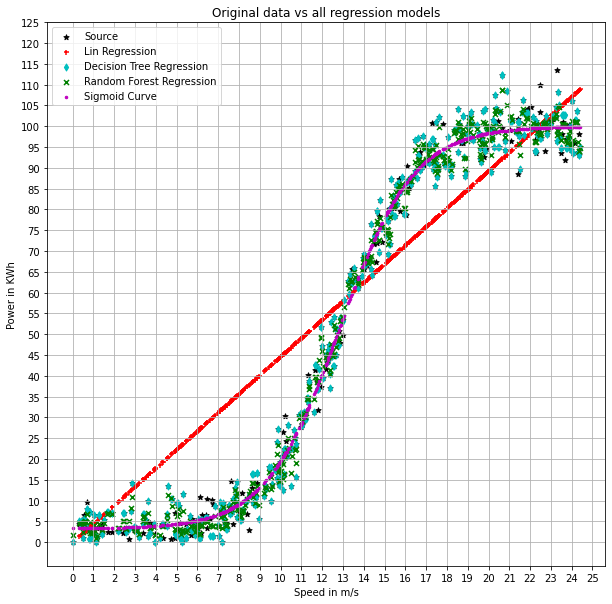

In [134]:
plt.figure(figsize = (10, 10))
plt.scatter(cleansed_df["speed"], cleansed_df["power"], s = 30, color = "k", marker = "*", label = "Source")
plt.scatter(Analysis_df["speed"], Analysis_df["Lin P"], s = 25, color = "r", marker = "+", label = "Lin Regression")
plt.scatter(Analysis_df["speed"], Analysis_df["DTR P"], s = 25, color = "c", marker = "d", label = "Decision Tree Regression")
plt.scatter(Analysis_df["speed"], Analysis_df["RFR P"], s = 25, color = "g", marker = "x", label = "Random Forest Regression")
plt.scatter(Analysis_df["speed"], Analysis_df["Sig P"], s = 25, color = "m", marker = ".", label = "Sigmoid Curve")
plt.xticks(np.arange(0, round(cleansed_df["speed"].max(), 0) + 2, step = 1)) # Force all the xticks to be visible
plt.yticks(np.arange(0, round(Analysis_df[["power", "Lin P", "DTR P", "RFR P", "Sig P"]].max(axis=1)[j-1] + 18), step = 5)) # Force all the xticks to be visible
plt.grid(which = "major", axis = "x")                           # Show the minor grid lines on the x axis
plt.grid(which = "major", axis = "y")                           # Show the minor grid lines on the y axis
plt.ylabel("Power in KWh")
plt.xlabel("Speed in m/s")
plt.legend(loc = "best")
plt.title("Original data vs all regression models")
plt.show()